In [14]:
# loading the subset data

import os
import pandas as pd

subset_folder = "subsets_trial5"
csv_files = [f for f in os.listdir(subset_folder) if f.endswith('.csv')]

dfs = []
for file in csv_files:
    file_path = os.path.join(subset_folder, file)
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
    except UnicodeDecodeError:
        print(f"⚠️ UTF-8 failed for {file}, trying ISO-8859-1...")
        df = pd.read_csv(file_path, encoding='ISO-8859-1')
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.loc[:, ~df_all.columns.str.startswith('Unnamed:')]
df_all = df_all[df_all['description'] != 'ERROR']
df_all['id_EXIST'] = df_all['id_EXIST'].astype('Int64')
df_all = df_all[df_all['id_EXIST'].notna()]


FileNotFoundError: [Errno 2] No such file or directory: 'subsets_trial5'

In [15]:
# df_all

In [10]:
# Filter for mismatches between target and label
pd.set_option('display.max_colwidth', None)
mismatches = df_all[
    ((df_all['target'] == 1.0) & (df_all['label'] == 'NO')) |
    ((df_all['target'] == 0.0) & (df_all['label'] == 'YES'))
]

print(f"Found {len(mismatches)} mismatches between target and label")
print("\nMismatch examples:")
mismatches[['text', 'target', 'label', 'description','path_video','analysis']]


Found 186 mismatches between target and label

Mismatch examples:


,text,target,label,description,path_video,analysis
2,"don’t laugh at your girlfriends choice, you are one if them rolling_on_the_floor_laughing face_with_tears_of_joy never laugh at your girlfriend's love. have a fabulous day. you should never laugh at your girlfriend's choice because you're one of them.",0.0,YES,A woman tells a joke: 'You should never laugh at your girlfriend's choice because you're one of them.',videos/7123342389338443009.mp4,"The joke implies that women make poor choices, including in their partners, which is a sexist generalization. It subtly reinforces the idea that men are a 'choice' that can be laughed at, playing on gender stereotypes."
5,the struggle is real is caffeinated. most men will never understand the struggle of putting on leggings or skinny jeans on freshly lotioned legs.,0.0,YES,"A woman with purple hair and dark lipstick describes the difficulty of putting on tight pants like leggings or skinny jeans over freshly lotioned legs, stating that most men will never understand this struggle.",videos/7067715837255470383.mp4,"The video embodies sexism by making a broad generalization that 'most men will never understand' a specific experience, thereby reinforcing gender stereotypes about differing experiences and understanding based purely on gender. This perpetuates a stereotypical divide, suggesting an inherent lack of empathy or shared experience across genders regarding this particular everyday inconvenience."
9,"$178.00 bathing suit!? just why thinking_face and made me do it flushed_face ""42, do you have any questions about the 42nd episode of pcos support girleeyaa? also, have you checked out mikayla nogueira's page for updates? #gfo"" what's a waist over five inches? oh my god! would you believe me if i told you this is 178 dollars. absolutely not. it's $178. no one mentions that. okay, here it is. untied. i'm a size medium for reference. i'm 165 pounds, 4'11"", and cody's gonna do the honor of pulling the strings all right oh all right he's tying it in the back. wow. do we think it worked? it's actually not. it doesn't feel tight at all. it feels pretty comfortable. it looks good, right? it does. i do look snatched, okay? ooh! one more time, here's the before, and here is the after.",0.0,YES,"The video shows two women, one slim and one plus-size, trying on a shaping swimsuit that cinches the waist, with the plus-size woman and her partner reacting positively to the 'snatched' effect.",videos/6987866527894686981.mp4,"The video arguably embodies sexism by promoting and celebrating a garment that alters women's bodies to conform to a specific, gendered beauty ideal (a 'snatched' waist), thereby reinforcing societal pressures on female appearance."
11,"there're some exceptions of course grinning_face_with_sweat high-heeled_shoe american women on dates europeans cjojo_wagner 0 utk trtk 0 ttk trk 0 no, i'll get there myself. i'm an independent woman, and, you know, just in case you're- you're three minutes late, and i can see you have no flowers for me. wow. okay. we're gonna have a very good time. i bet. yeah. okay. okay.",0.0,YES,"A TikTok video contrasts stereotypical dating expectations of ""American women"" emphasizing independence with ""Eastern European women"" emphasizing traditional romantic gestures like flowers.",videos/6931726886422793473.mp4,"The video embodies sexism by presenting and reinforcing gender stereotypes about women's dating expectations based on their cultural background. The portrayal of the ""Eastern European"" woman, who expects flowers and is upset by their absence, relies on traditional gender roles and can be seen as a prejudicial caricature."
13,don’t mess with him eyes these hands are very important. i got bitches off the zans bitch i got,0.0,YES,"The video features clips of cats with text overlay saying ""BITCHES"" and ""These hands"" while an audio track plays saying ""I got bitches off the Zans. Bitch I got bitches..."" followed by a song.",videos/68951616364

In [11]:
# # Save mismatches to CSV
# # Create eval_results directory if it doesn't exist
# os.makedirs("eval_results", exist_ok=True)

# # Save mismatches to CSV
# mismatches.to_csv("eval_results/trial1_fp.csv")


In [12]:
# First, map 'YES' to 1.0 and 'NO' to 0.0 in the label column
df_all['label_num'] = df_all['label'].map({'YES': 1.0, 'NO': 0.0})

# Now compare predicted vs actual
accuracy = (df_all['label_num'] == df_all['target']).mean()

print(f"Accuracy: {accuracy:.2%}")

Accuracy: 73.65%


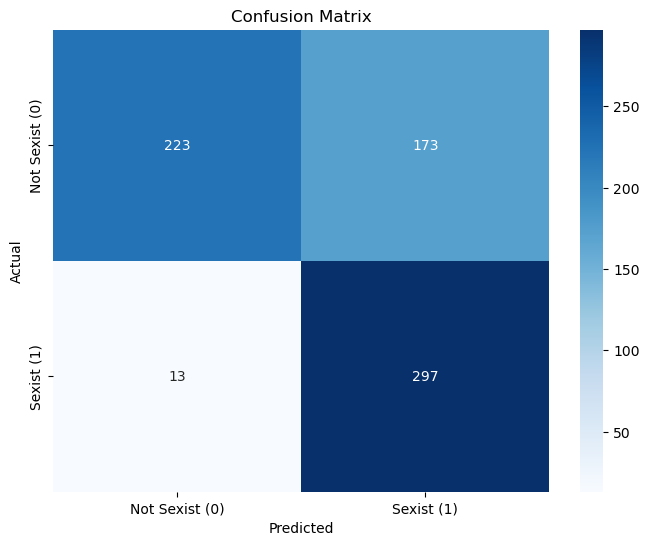

In [13]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_all['target'], df_all['label_num'])

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sexist (0)', 'Sexist (1)'],
            yticklabels=['Not Sexist (0)', 'Sexist (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


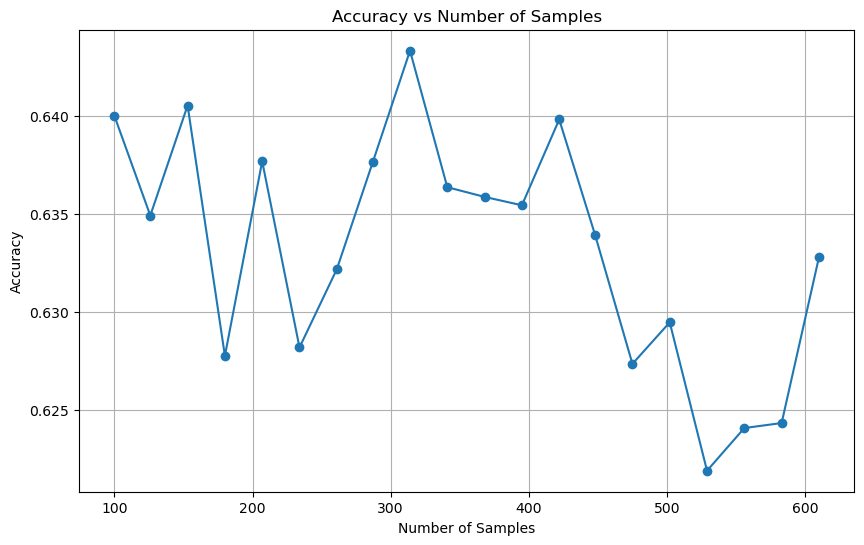

Final accuracy with all 610 samples: 63.28%


In [125]:
# Calculate accuracy with increasing samples
import numpy as np

# Create a copy of df_all and shuffle it
df_shuffled = df_all.sample(frac=1, random_state=np.random.randint(1000)).reset_index(drop=True)

# Create list to store accuracies
sample_sizes = np.linspace(100, len(df_shuffled), num=20, dtype=int)
accuracies = []

# Calculate accuracy for each sample size
for size in sample_sizes:
    # Take first n samples from shuffled dataframe
    sample = df_shuffled.iloc[:size]
    # Calculate accuracy
    acc = (sample['label_num'] == sample['target']).mean()
    accuracies.append(acc)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, accuracies, marker='o')
plt.title('Accuracy vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Print final accuracy
print(f"Final accuracy with all {len(df_shuffled)} samples: {accuracies[-1]:.2%}")



In [126]:
print(df_all['id_EXIST'].nunique())
print(len(df_all))
assert df_all['id_EXIST'].nunique() == len(df_all), "Duplicate id_EXIST values found!"

610
610


In [ ]:
import json

# Load your allowed IDs
allowed_ids = set(df_all["id_EXIST"].astype(str))
print(len(allowed_ids))

# Load input JSON file
with open('/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/eval/EXIST2025_training_task3_1_gold_hard.json', 'r') as f:
    data = json.load(f)

# Filter for only matching IDs
actual_data = [item for item in data if item.get("id") in allowed_ids]

with open("actual_data.json", "w") as f:
    json.dump(actual_data, f, indent=2)



610


In [26]:
print(len(actual_data))

955


In [27]:
# predicted data 
predicted_output = [
    {
        "test_case": "EXIST2025",
        "id": str(row["id_EXIST"]),
        "value": row["label"]
    }
    for _, row in df_all.iterrows()
]

predicted_output
# # Optional: save to a .json file
import json
with open("predicted_output.json", "w") as f:
    json.dump(predicted_output, f, indent=2)


In [28]:
from pyevall.evaluation import PyEvALLEvaluation
from pyevall.utils.utils import PyEvALLUtils

# Path to your prediction and gold label files
predictions = '/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/gemini/actual_data.json'
gold        = '/Volumes/T7/OMSCS/CLEF2025/EXIST2025/exist-2025/notebooks/gemini/predicted_output.json'

# Create a PyEvALL evaluation object
test = PyEvALLEvaluation()

# Set evaluation parameters: here, ask for an embedded report
params = dict()
params[PyEvALLUtils.PARAM_REPORT] = PyEvALLUtils.PARAM_OPTION_REPORT_EMBEDDED

# List of metrics to evaluate
metrics = ["ICM", "ICMNorm", "FMeasure"]

# Run the evaluation
report = test.evaluate(predictions, gold, metrics, **params)





2025-05-13 21:58:16,209 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-05-13 21:58:16,272 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-13 21:58:16,387 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-05-13 21:58:16,388 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-13 21:58:16,503 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-05-13 21:58:16,618 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method


In [29]:
# Print the report
report.print_report()

{
  "metrics": {
    "ICM": {
      "name": "Information Contrast model",
      "acronym": "ICM",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.286537036135474
        }],
        "average_per_test_case": 0.286537036135474
      }
    },
    "ICMNorm": {
      "name": "Normalized Information Contrast Model",
      "acronym": "ICM-Norm",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "average": 0.6489373461578782
        }],
        "average_per_test_case": 0.6489373461578782
      }
    },
    "FMeasure": {
      "name": "F-Measure",
      "acronym": "F1",
      "description": "Coming soon!",
      "status": "OK",
      "results": {
        "test_cases": [{
          "name": "EXIST2025",
          "classes": {
            "YES": 0.7825242718446602,
            "NO": 0.7485907553551